Imports

In [29]:
import feed_forward
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import geoopt
from time import time
from torchvision import datasets, transforms
import helper
torch.cuda.is_available()

True

CUDA check

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Data Transformation

In [31]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,)), 
                              ])

Training and Test data from MNIST data set

In [32]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
n_inputs = 784
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=512, shuffle=True)

Initializing the model

In [33]:
model = feed_forward.HypFF(784, 512, 256, 10)
model.to(device)

HypFF(
  (fc1): MobLinear(
    in_features=784, out_features=512, bias=True
    (ball): PoincareBall manifold
  )
  (fc2): MobLinear(
    in_features=512, out_features=256, bias=True
    (ball): PoincareBall manifold
  )
  (fc3): MobLinear(
    in_features=256, out_features=10, bias=True
    (ball): PoincareBall manifold
  )
)

In [34]:
print(model)

HypFF(
  (fc1): MobLinear(
    in_features=784, out_features=512, bias=True
    (ball): PoincareBall manifold
  )
  (fc2): MobLinear(
    in_features=512, out_features=256, bias=True
    (ball): PoincareBall manifold
  )
  (fc3): MobLinear(
    in_features=256, out_features=10, bias=True
    (ball): PoincareBall manifold
  )
)


Hyperparameters

In [35]:
#learning_rate = 64e-1 #learning rate for logSigmoid activation function
learning_rate = 2e-1 #learning rate for ReLU activation function
#learning_rate = 2e-1 #current learning rate for model without activation functions
momentum = 0.9

Loss Function

In [36]:
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images, labels = images.to(device), labels.to(device)
images = 0.0357*images.view(images.shape[0], -1)
print(images)

out = model(images) #output
print(out)
loss = criterion(out, labels) #calculate the loss

tensor([[-0.0151, -0.0151, -0.0151,  ..., -0.0151, -0.0151, -0.0151],
        [-0.0151, -0.0151, -0.0151,  ..., -0.0151, -0.0151, -0.0151],
        [-0.0151, -0.0151, -0.0151,  ..., -0.0151, -0.0151, -0.0151],
        ...,
        [-0.0151, -0.0151, -0.0151,  ..., -0.0151, -0.0151, -0.0151],
        [-0.0151, -0.0151, -0.0151,  ..., -0.0151, -0.0151, -0.0151],
        [-0.0151, -0.0151, -0.0151,  ..., -0.0151, -0.0151, -0.0151]],
       device='cuda:0')
tensor([[ 0.0325,  0.0234, -0.0345,  ..., -0.0298, -0.0048, -0.0049],
        [ 0.0259,  0.0088, -0.0117,  ..., -0.0138, -0.0103, -0.0099],
        [ 0.0448,  0.0261, -0.0267,  ..., -0.0241, -0.0211, -0.0146],
        ...,
        [ 0.0468,  0.0257, -0.0009,  ..., -0.0244, -0.0203, -0.0105],
        [ 0.0243,  0.0301, -0.0362,  ..., -0.0393, -0.0190, -0.0124],
        [ 0.0540,  0.0296, -0.0146,  ..., -0.0280, -0.0193, -0.0156]],
       device='cuda:0', grad_fn=<SWhereBackward>)


Optimizer

In [37]:
optimizer = geoopt.optim.RiemannianSGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [38]:

time0 = time()

epochs = 10
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        # Flatten MNIST images into a 784 long vector
        images = 0.0357*images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #backpropagation
        loss.backward()
        
        #Weight optimization
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 1.6956563652571985
Epoch 1 - Training loss: 1.4856361878120292
Epoch 2 - Training loss: 1.461784232470949
Epoch 3 - Training loss: 1.4509121735217207
Epoch 4 - Training loss: 1.443927731554387
Epoch 5 - Training loss: 1.4390269447181185
Epoch 6 - Training loss: 1.4359774367283966
Epoch 7 - Training loss: 1.4335576780771806
Epoch 8 - Training loss: 1.4318013767064628
Epoch 9 - Training loss: 1.4299342743421004

Training Time (in minutes) = 2.891225612163544


tensor([[-0.0877, -0.1474, -0.1010, -0.1111, -0.0761,  0.9456, -0.0774, -0.1089,
         -0.1248, -0.0812]])
[-0.08767295, -0.14743598, -0.10104416, -0.111054465, -0.076088525, 0.94563955, -0.07739172, -0.10891745, -0.12478899, -0.08124332]
Predicted Digit = 5


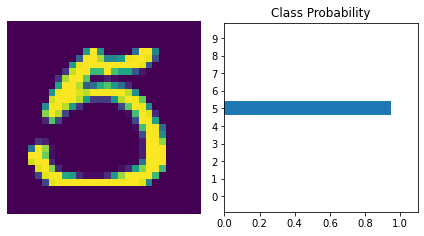

In [39]:
images, labels = next(iter(valloader))
#images, labels = images.to(device), labels.to(device)

img = 0.0357*images[0].view(1, 784)
img_gpu = img.to(device)
with torch.no_grad():
    out = model(img_gpu)

ps = out.cpu()
print(ps)
probab = list(ps.numpy()[0])
print(probab)
print("Predicted Digit =", probab.index(max(probab)))
helper.view_classify(img.view(1, 28, 28), ps)

In [40]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  images, labels = images.to(device), labels.to(device)
  for i in range(len(labels)):
    img = 0.0357*images[i].view(1, 784)
    with torch.no_grad():
        out = model(img)

    
    ps = out.cpu()
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu().numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9836


Current status of experiments:
1. Using just Hyperboic Linear modules, and with the appropriate self-tuned hyperparameters, and a batch size of 512, the average accuracy was around 90 percent
2. With the use of activation functions(ReLu, ReLu, then LogSoftMax at the output layer), (by applying the functions in the tangent space, then mapping it back to the hyperbolic space), we see an increase in the model accuracy to about 97-98 percent.
3. To account for the correct class probabilities , linear layer was used as the output layer instead, together with the crossentropy loss function.